# 权重衰减

上一节中我们观察了过拟合现象，即模型的训练误差远小于它在测试数据集上的误差。本节将介绍应对过拟合问题的常用方法：权重衰减。


## $L_2$ 范数正则化

在深度学习中，我们常使用 $L_2$ 范数正则化，也就是在模型原先损失函数基础上添加 $L_2$ 范数惩罚项，从而得到训练所需要最小化的函数。$L_2$ 范数惩罚项指的是模型权重参数每个元素的平方和与一个超参数的乘积。以 [“线性回归”](linear-regression.md) 一节中线性回归的损失函数 $\ell(w_1, w_2, b)$ 为例（$w_1, w_2$ 是权重参数，$b$ 是偏差参数），带有 $L_2$ 范数惩罚项的新损失函数为

$$\ell(w_1, w_2, b) + \frac{\lambda}{2}(w_1^2 + w_2^2),$$

其中超参数 $\lambda > 0$。当权重参数均为 0 时，惩罚项最小。当 $\lambda$ 较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近 0。当 $\lambda$ 设为 0 时，惩罚项完全不起作用。

有了 $L_2$ 范数惩罚项后，在小批量随机梯度下降中，我们将 [“线性回归”](linear-regression.md) 一节中权重 $w_1$ 和 $w_2$ 的迭代方式更改为

$$w_1 \leftarrow w_1 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} (x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}) - \lambda w_1,$$

$$w_2 \leftarrow w_2 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} (x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}) - \lambda w_2.$$


可见，$L_2$ 范数正则化令权重 $w_1$ 和 $w_2$ 的每一步迭代分别添加了 $- \lambda w_1$ 和 $- \lambda w_2$。因此，我们有时也把 $L_2$ 范数正则化称为权重衰减（weight decay）。

实际场景中，我们有时也在惩罚项中添加偏差元素的平方和。假设神经网络中某一个神经元的输入是 $x_1, x_2$，使用激活函数 $\phi$ 并输出 $\phi(x_1 w_1 + x_2 w_2 + b)$。假设激活函数 $\phi$ 是 ReLU、tanh 或 sigmoid，如果 $w_1, w_2, b$ 都非常接近 0，那么输出也接近 0。也就是说，这个神经元的作用比较小，甚至就像是令神经网络少了一个神经元一样。上一节我们提到，给定训练数据集，过高复杂度的模型容易过拟合。因此，$L_2$ 范数正则化可能对过拟合有效。

## 高维线性回归实验

下面，我们通过高维线性回归为例来引入一个过拟合问题，并使用 $L_2$ 范数正则化来试着应对过拟合。

### 生成数据集

设数据样本特征的维度为 $p$。对于训练数据集和测试数据集中特征为 $x_1, x_2, \ldots, x_p$ 的任一样本，我们使用如下的线性函数来生成该样本的标签：

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \epsilon,$$

其中噪音项 $\epsilon$ 服从均值为 0 和标准差为 0.1 的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，例如设维度 $p=200$；同时，我们特意把训练数据集的样本数设低，例如 20。

In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, gluon, nd

n_train = 20
n_test = 100

num_inputs = 200
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

features = nd.random.normal(shape=(n_train+n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 初始化模型参数

接着，定义随机初始化模型参数的函数。该函数也给每个参数都附上梯度。

In [2]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    for param in params:
        param.attach_grad()
    return params

### 定义 $L_2$ 范数惩罚项

下面定义 $L_2$ 范数惩罚项。这里只惩罚模型的权重参数。

In [3]:
def l2_penalty(w):
    return (w**2).sum() / 2

### 定义训练和测试

下面定义如何在训练数据集和测试数据集上分别训练和测试模型。和前面几节中不同的是，这里在计算最终的损失函数时添加了 $L_2$ 范数惩罚项。

In [4]:
batch_size = 1
num_epochs = 10
lr = 0.003

net = gb.linreg
loss = gb.squared_loss
%config InlineBackend.figure_format = 'retina'
gb.plt.rcParams['figure.figsize'] = (3.5, 2.5)

def fit_and_plot(lambd):
    w, b = params = init_params()
    train_ls = []
    test_ls = []
    for _ in range(num_epochs):        
        for X, y in gb.data_iter(batch_size, features, labels):
            with autograd.record():
                # 添加了 L2 范数惩罚项。
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            gb.sgd(params, lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    return 'w[:10]:', w[:10].T, 'b:', b

### 观察过拟合

接下来，让我们训练并测试高维线性回归模型。当 `lambd` 设为 0 时，我们没有使用正则化。结果训练误差远小于测试数据集上的误差。这是典型的过拟合现象。

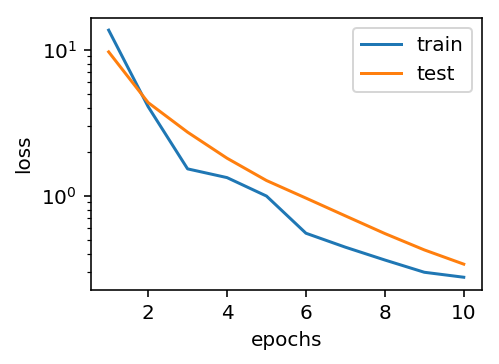

('w[:10]:', 
 [[ 0.09979543  0.05102992 -0.21108846 -1.17206442 -0.64181107 -0.61234105
   -0.23525077  0.65376961 -0.93419266 -0.71765995]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [-0.05805291]
 <NDArray 1 @cpu(0)>)

In [5]:
fit_and_plot(lambd=0)

### 使用正则化

下面我们使用 $L_2$ 范数正则化。我们发现训练误差虽然有所提高，但测试数据集上的误差有所下降。过拟合现象得到一定程度上的缓解。另外，学到的权重参数的绝对值比不使用正则化时的权重参数更接近 0。

然而，即便是使用了正则化的模型依然没有学出较准确的模型参数。这主要是因为训练数据集的样本数相对维度来说太小。

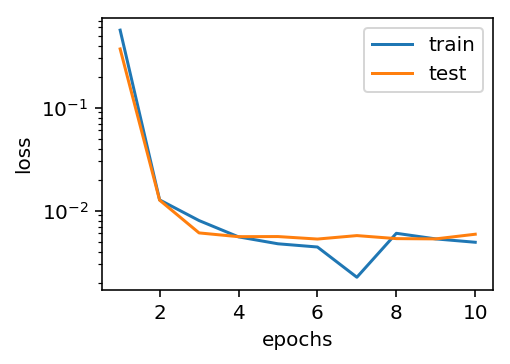

('w[:10]:', 
 [[ 0.00385251  0.00217324  0.0023132   0.00153545  0.00087176 -0.00050074
    0.00208535  0.0001479  -0.00053794  0.00099484]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [ 0.05672078]
 <NDArray 1 @cpu(0)>)

In [6]:
fit_and_plot(lambd=5)

## 小结

* 我们可以使用权重衰减来应对过拟合问题。
* $L_2$ 范数正则化通常会使学到的权重参数的元素较接近 0。
* $L_2$ 范数正则化也叫权重衰减。

## 练习

* 除了正则化、增大训练量、以及使用复杂度合适的模型，你还能想到哪些办法可以应对过拟合现象？
* 如果你了解贝叶斯统计，你觉得 $L_2$ 范数正则化对应贝叶斯统计里的哪个重要概念？

## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/984)

![](../img/qr_weight-decay.svg)